In [31]:
import numpy as np
from scipy.integrate import odeint
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import erf
from scipy.stats import chi2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### confronto regionale

In [18]:
name_regions       = np.array(['Abruzzo','Basilicata','P.A. Bolzano','Calabria','Campania','Emilia-Romagna','Friuli Venezia Giulia','Lazio','Liguria','Lombardia','Marche','Molise','Piemonte','Puglia','Sardegna','Sicilia','Toscana','P.A. Trento','Umbria','Valle d\'Aosta','Veneto'])
#popolation_regions = np.array([1311580, 562869,520891, 1947131, 5801692, 4459477, 1215220, 5879082, 1550640, 10060574, 1525271, 305617, 4356406, 4029053, 1639591, 4999891, 3729641,538223, 882015, 125666, 4905854])

popolation_regions = np.array([1304970, 559084,533050, 1947131, 5801692, 4459477, 1215220, 5879082, 1550640, 10060574, 1525271, 305617, 4356406, 4029053, 1639591, 4999891, 3729641,541380, 882015, 125666, 4905854])

df_regpop=pd.DataFrame(popolation_regions)
df_regpop.index=name_regions 
df_regpop.columns=['popolazione']

df_regpop

,popolazione
Abruzzo,1304970
Basilicata,559084
P.A. Bolzano,533050
Calabria,1947131
Campania,5801692
Emilia-Romagna,4459477
Friuli Venezia Giulia,1215220
Lazio,5879082
Liguria,1550640
Lombardia,10060574


In [19]:
datatot = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')

# regional parameters

def datiregione(nome,t=-1):
    data_reg=datatot[datatot['denominazione_regione']==nome].iloc[t,:]
    
    popolazione=df_regpop.loc[nome].values
    infetti=data_reg['totale_positivi']/popolazione*1000
    tamponi=-data_reg['tamponi']/popolazione*1000
    ospedalizzati=data_reg['totale_ospedalizzati']/popolazione*1000
    infetti_7daysago=datatot[datatot['denominazione_regione']==nome].iloc[t-7,:].totale_positivi/popolazione*1000
    variazione=(infetti-infetti_7daysago)/infetti_7daysago*100
    tampinf=tamponi/infetti
    intensiva=data_reg['terapia_intensiva']/popolazione*1000
    intensinf=intensiva/infetti
    
    sn=(popolazione-10*datatot[datatot['denominazione_regione']==nome].iloc[t,:].totale_casi)/popolazione
    
    return infetti, tamponi, ospedalizzati, variazione, tampinf, sn

In [20]:
#datatot[datatot['denominazione_regione']=='Umbria'].iloc[-1]

datiregione('Umbria')

(array([0.1258482]),
 array([-51.67032307]),
 array([0.05782215]),
 array([-43.36734694]),
 array([-410.57657658]),
 array([0.98404789]))

In [21]:
# national average

def datinazione(t=-1):
    arr=[]

    for nome in name_regions:
        reg_data=datiregione(nome,t)
        arr.append(np.array(reg_data))
    
    arr=np.array(arr)
    arr=arr[:,0:len(reg_data)-1]
    
    naz_mean=np.mean(arr,axis=0)
    naz_std=np.std(arr,axis=0)

    return naz_mean,naz_std

print('mean ',datinazione()[0])
print('std dev ',datinazione()[1])

mean  [[  1.12062406]
 [-46.78124157]
 [  0.18713001]
 [-15.2421659 ]
 [-70.16097527]]
std dev  [[ 0.842857  ]
 [23.77680478]
 [ 0.15719671]
 [14.81133181]
 [81.57628715]]


In [22]:
naz_data_std=datinazione(t=-1)
naz_mean_std=naz_data_std[0]
naz_std_std=naz_data_std[1]

In [23]:
# comparison with national values

def datiregion_confr(nome,t=-1,scelta=1):
    tulpe=datiregione(nome,t)
    arr=tulpe[0:5]
    
    if scelta==1:
        naz_mean=naz_mean_std
        naz_std=naz_std_std
    else:
        naz_data=datinazione(t)
        naz_mean=naz_data[0]
        naz_std=naz_data[1]
    
    result=(arr-naz_mean)/naz_std
    result_m=np.mean(result)
    
    gauss_res=(erf(result_m/np.sqrt(2))+1)/2*100*tulpe[5]
    #gauss_res=chi2.cdf(np.sum(result),5)*tulpe[5]*100
    
    #print(np.sum(result))
    
    #print(tulpe[4])
    
    
    return int(gauss_res),round(result[0][0],2),round(result[1][0],2),round(result[2][0],2),round(result[3][0],2), round(result[4][0],2),round(tulpe[5][0],3)

In [24]:
risiko=[]

for nome in name_regions:
    
    reg_cfr=datiregion_confr(nome)
    
    risiko.append(reg_cfr)
    
df_risiko=pd.DataFrame(risiko)
df_risiko.index=name_regions
df_risiko.columns=['Rischio','Infetti','Tamponi','Ospedalizzati','Variazione','Tamponi/Infetti','SN']

df_risiko.sort_values(by='Rischio',ascending=False)

,Rischio,Infetti,Tamponi,Ospedalizzati,Variazione,Tamponi/Infetti,SN
Piemonte,80,2.47,-0.02,1.95,0.26,0.68,0.934
Lombardia,78,2.24,-0.03,2.52,-0.15,0.67,0.919
Marche,68,1.18,-0.07,0.13,1.08,0.58,0.957
Liguria,66,0.95,0.21,1.04,-0.13,0.59,0.944
Lazio,63,-0.45,0.72,0.28,0.87,0.37,0.988
Valle d'Aosta,60,-0.22,-1.19,1.24,2.41,-0.12,0.908
Molise,60,-0.53,0.77,-1.02,1.88,0.34,0.989
Abruzzo,60,0.19,0.45,0.06,0.30,0.51,0.976
Emilia-Romagna,60,0.64,-0.18,1.32,-0.36,0.48,0.940
Puglia,57,-0.53,1.17,-0.60,0.51,0.52,0.989


## stabilità parametro

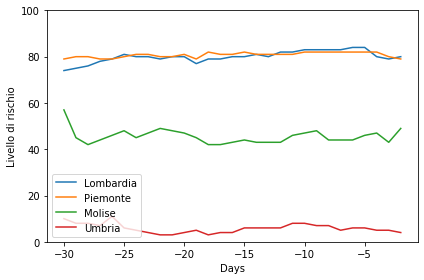

In [25]:
timegrid=np.arange(-30,-1,1)

datiregion_confr_vec=np.vectorize(datiregion_confr)

plt.plot(timegrid,datiregion_confr_vec('Lombardia',timegrid,scelta=2)[0],label='Lombardia')
plt.plot(timegrid,datiregion_confr_vec('Piemonte',timegrid,scelta=2)[0],label='Piemonte')
plt.plot(timegrid,datiregion_confr_vec('Molise',timegrid,scelta=2)[0],label='Molise')
plt.plot(timegrid,datiregion_confr_vec('Umbria',timegrid,scelta=2)[0],label='Umbria')
plt.xlabel('Days')
plt.ylabel('Livello di rischio')
plt.ylim(0,100)
plt.legend()
plt.tight_layout()
#plt.savefig('output3/nuovo_param_rischio.png',dpi=300)
plt.show()

In [26]:
chi2.cdf(5,5)

0.584119813004492

# PCA

In [140]:

def datiregione(nome,t=-1):
    data_reg=datatot[datatot['denominazione_regione']==nome].iloc[t,:]
    
    popolazione=df_regpop.loc[nome].values
    infetti=data_reg['totale_positivi']/popolazione*1000
    tamponi=-data_reg['tamponi']/popolazione*1000
    ospedalizzati=data_reg['totale_ospedalizzati']/popolazione*1000
    infetti_7daysago=datatot[datatot['denominazione_regione']==nome].iloc[t-7,:].totale_positivi/popolazione*1000
    variazione=(infetti-infetti_7daysago)/infetti_7daysago*100
    tampinf=tamponi/infetti
    intensiva=data_reg['terapia_intensiva']/popolazione*1000
    intensinf=intensiva/infetti
    infettipop = infetti/popolazione
    ospedalizzatiinf = ospedalizzati/infetti
    tamppop = tamponi/popolazione
    intensivaosp = intensiva/ospedalizzati
    sn=(popolazione-10*datatot[datatot['denominazione_regione']==nome].iloc[t,:].totale_casi)/popolazione
    
    return infetti, tamponi, ospedalizzati, variazione, tampinf, sn, intensiva, intensinf, infettipop, ospedalizzatiinf, tamppop, intensivaosp

In [184]:
risiko=[]

for nome in name_regions:
    
    reg_cfr=datiregione(nome)
    reg_cfr=[x[0] for x in datiregione(nome)]
    risiko.append(reg_cfr)
    
df_indicatori=pd.DataFrame(risiko)
df_indicatori.index=name_regions
df_indicatori.columns=['Infetti','Tamponi','Ospedalizzati','Variazione','Infetti/Tamponi', 'SN', 'Intensiva', 'Intensiva/Infetti', "Infetti/popolazione", "Ospedalizzati/Infetti", "Tamponi/popolazione", "Intensiva/ospedalizzati"]

df_indicatori

,Infetti,Tamponi,Ospedalizzati,Variazione,Infetti/Tamponi,SN,Intensiva,Intensiva/Infetti,Infetti/popolazione,Ospedalizzati/Infetti,Tamponi/popolazione,Intensiva/ospedalizzati
Abruzzo,1.284321,-36.161751,0.196173,-10.803619,-28.156325,0.976352,0.007663,0.005967,9.841764e-07,0.152745,-0.000028,0.039062
Basilicata,0.259353,-31.181361,0.082277,-24.083770,-120.227586,0.993167,0.001789,0.006897,4.638888e-07,0.317241,-0.000056,0.021739
P.A. Bolzano,0.887346,-91.657443,0.120064,-32.716927,-103.293869,0.951843,0.016884,0.019027,1.664659e-06,0.135307,-0.000172,0.140625
Calabria,0.314309,-23.147390,0.035950,-14.165498,-73.645425,0.994202,0.001027,0.003268,1.614214e-07,0.114379,-0.000012,0.028571
Campania,0.338694,-19.099773,0.076012,-27.783903,-56.392366,0.992113,0.004481,0.013232,5.837854e-08,0.224427,-0.000003,0.058957
Emilia-Romagna,1.659612,-50.984902,0.394441,-20.615682,-30.720984,0.940085,0.034757,0.020943,3.721539e-07,0.237671,-0.000011,0.088118
Friuli Venezia Giulia,0.715097,-72.730864,0.085581,-21.641118,-101.707710,0.974293,0.002469,0.003452,5.884505e-07,0.119678,-0.000060,0.028846
Lazio,0.739061,-29.672660,0.231159,-2.403414,-40.149137,0.987867,0.013948,0.018872,1.257103e-07,0.312773,-0.000005,0.060338
Liguria,1.923077,-41.870453,0.350178,-17.120623,-21.772636,0.943649,0.027086,0.014085,1.240183e-06,0.182093,-0.000027,0.077348
Lombardia,3.007979,-47.488841,0.582969,-17.468023,-15.787621,0.919264,0.032801,0.010905,2.989869e-07,0.193807,-0.000005,0.056266


In [185]:
df_indicatori.corr()

,Infetti,Tamponi,Ospedalizzati,Variazione,Infetti/Tamponi,SN,Intensiva,Intensiva/Infetti,Infetti/popolazione,Ospedalizzati/Infetti,Tamponi/popolazione,Intensiva/ospedalizzati
Infetti,1.000000,-0.267148,0.852273,0.119475,0.463120,-0.729323,0.832950,-0.179562,0.070192,-0.238585,0.079784,0.097943
Tamponi,-0.267148,1.000000,-0.196567,0.240058,0.168055,0.662135,-0.327154,-0.144499,-0.450221,0.031878,0.487226,-0.333993
Ospedalizzati,0.852273,-0.196567,1.000000,0.201540,0.352032,-0.799233,0.897679,0.060271,0.258436,0.196925,-0.177005,-0.003083
Variazione,0.119475,0.240058,0.201540,1.000000,0.488184,-0.092674,0.064637,-0.353226,0.504009,-0.100290,-0.384856,-0.407113
Infetti/Tamponi,0.463120,0.168055,0.352032,0.488184,1.000000,-0.211162,0.319110,-0.746144,0.047365,-0.602884,0.117362,-0.173668
SN,-0.729323,0.662135,-0.799233,-0.092674,-0.211162,1.000000,-0.823115,-0.108853,-0.599481,-0.091267,0.531499,-0.193331
Intensiva,0.832950,-0.327154,0.897679,0.064637,0.319110,-0.823115,1.000000,0.201128,0.236139,0.102116,-0.155756,0.374720
Intensiva/Infetti,-0.179562,-0.144499,0.060271,-0.353226,-0.746144,-0.108853,0.201128,1.000000,0.103199,0.753634,-0.233999,0.544419
Infetti/popolazione,0.070192,-0.450221,0.258436,0.504009,0.047365,-0.599481,0.236139,0.103199,1.000000,0.248980,-0.963085,-0.057716
Ospedalizzati/Infetti,-0.238585,0.031878,0.196925,-0.100290,-0.602884,-0.091267,0.102116,0.753634,0.248980,1.000000,-0.388685,0.013935


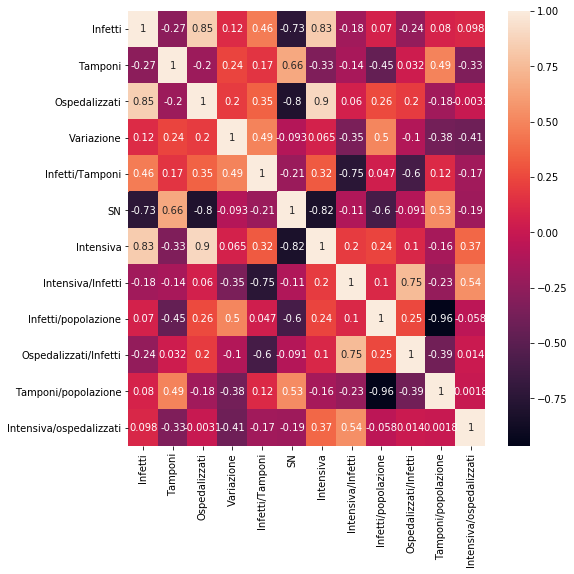

In [193]:
corrMatrix = df_indicatori.corr()
plt.figure(figsize = (8,))

ax = sn.heatmap(corrMatrix, annot=True)
plt.show()

In [196]:
def principal_component(subset_names):
    subset = df_indicatori[subset_names]
    print("Correlation matrix:")
    display(subset.corr())
    corrMatrix = subset.corr()
    plt.figure(figsize = (8,8))

    ax = sn.heatmap(corrMatrix, annot=True)
    plt.show()

    x = MinMaxScaler().fit_transform(subset.values)

    pca = PCA(n_components=1)
    pca.fit(x)
    print("\n\nPCA:")
    print("Explained variance ratio " + str(round(pca.explained_variance_ratio_[0], 2)), "\n")
    display(pd.DataFrame({'indicator':subset_names, 'weight':pca.components_[0].tolist()}))

    principalComponents = pca.fit_transform(x)
    principalComponents = MinMaxScaler().fit_transform(principalComponents)

    principalDf = pd.DataFrame(data = principalComponents*100
                , columns = ['Risk'])
    principalDf.index =  subset.index
    principalDf = principalDf.sort_values(by='Risk',ascending=False)
    display(principalDf)
    return principalDf

Correlation matrix:


,Infetti,Tamponi,Ospedalizzati,Infetti/Tamponi,SN
Infetti,1.000000,-0.267148,0.852273,0.463120,-0.729323
Tamponi,-0.267148,1.000000,-0.196567,0.168055,0.662135
Ospedalizzati,0.852273,-0.196567,1.000000,0.352032,-0.799233
Infetti/Tamponi,0.463120,0.168055,0.352032,1.000000,-0.211162
SN,-0.729323,0.662135,-0.799233,-0.211162,1.000000


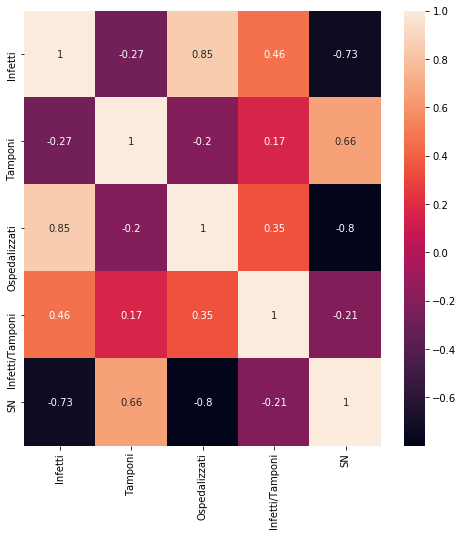



PCA:
Explained variance ratio 0.63 



,indicator,weight
0,Infetti,0.466954
1,Tamponi,-0.397597
2,Ospedalizzati,0.483971
3,Infetti/Tamponi,0.123692
4,SN,-0.611835


,Risk
Lombardia,100.000000
Piemonte,89.953059
Valle d'Aosta,81.988209
P.A. Trento,77.347590
Emilia-Romagna,67.920429
Liguria,63.449122
Marche,53.432764
P.A. Bolzano,52.401047
Veneto,48.899690
Friuli Venezia Giulia,32.150585


In [197]:
pc1 = principal_component(subset_names = ['Infetti', 'Tamponi', 'Ospedalizzati', 'Infetti/Tamponi', 'SN'])


Correlation matrix:


,Infetti,Tamponi,Infetti/Tamponi,Ospedalizzati,Intensiva
Infetti,1.000000,-0.267148,0.463120,0.852273,0.832950
Tamponi,-0.267148,1.000000,0.168055,-0.196567,-0.327154
Infetti/Tamponi,0.463120,0.168055,1.000000,0.352032,0.319110
Ospedalizzati,0.852273,-0.196567,0.352032,1.000000,0.897679
Intensiva,0.832950,-0.327154,0.319110,0.897679,1.000000


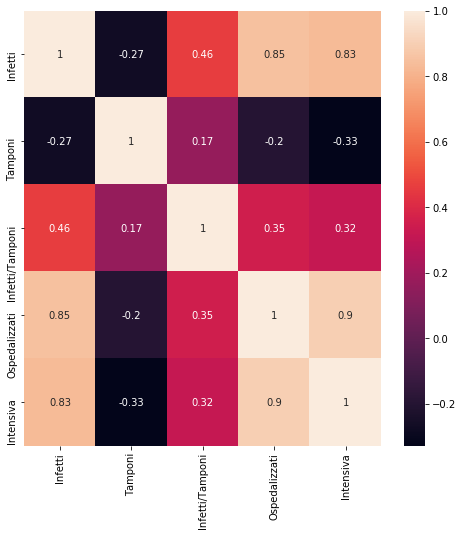



PCA:
Explained variance ratio 0.63 



,indicator,weight
0,Infetti,0.504928
1,Tamponi,-0.268227
2,Infetti/Tamponi,0.160604
3,Ospedalizzati,0.524460
4,Intensiva,0.610122


,Risk
Lombardia,100.000000
Piemonte,96.782953
Emilia-Romagna,77.992604
Liguria,68.005716
Valle d'Aosta,62.417461
Marche,56.596767
P.A. Trento,55.294809
P.A. Bolzano,42.306132
Toscana,41.537874
Veneto,34.625183


In [206]:
#['Infetti','Tamponi','Ospedalizzati','Variazione','Infetti/Tamponi', 'SN', 'Intensiva', 'Intensiva/Infetti', "Infetti/popolazione", "Ospedalizzati/Infetti", "Tamponi/popolazione", "Intensiva/ospedalizzati"]
pc2 = principal_component(subset_names = ['Infetti','Tamponi', 'Infetti/Tamponi','Ospedalizzati', 'Intensiva'])

In [217]:
pc1.columns = ["Rischio PCA1"]
pc2.columns = ["Rischio PCA2"]

results = df_risiko[['Rischio']].join(pc1, how="left")
results = results.join(pc2, how="left")
results = results.rank(method="first", ascending = False).sort_values(by='Rischio PCA2')

results['Diff1'] = results['Rischio'] - results['Rischio PCA1']
results['Diff2'] = results['Rischio'] - results['Rischio PCA2']
results

,Rischio,Rischio PCA1,Rischio PCA2,Diff1,Diff2
Lombardia,2.0,1.0,1.0,1.0,1.0
Piemonte,1.0,2.0,2.0,-1.0,-1.0
Emilia-Romagna,7.0,5.0,3.0,2.0,4.0
Liguria,4.0,6.0,4.0,-2.0,0.0
Valle d'Aosta,9.0,3.0,5.0,6.0,4.0
Marche,3.0,7.0,6.0,-4.0,-3.0
P.A. Trento,19.0,4.0,7.0,15.0,12.0
P.A. Bolzano,20.0,8.0,8.0,12.0,12.0
Toscana,12.0,12.0,9.0,0.0,3.0
Veneto,17.0,9.0,10.0,8.0,7.0
